In [29]:
import yfinance as yf

stock_tickers = ['MSFT','AAPL','TSLA','NVDA','NFLX','META']
database = yf.download(stock_tickers,start='2020-01-01',end='2024-06-30')
database = database['Adj Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,META,MSFT,NFLX,NVDA,TSLA
Date,,,,,,
2020-01-03 00:00:00+00:00,-0.009722,-0.005291,-0.012452,-0.011855,-0.016006,0.029633
2020-01-06 00:00:00+00:00,0.007968,0.018834,0.002585,0.030469,0.004194,0.019255
2020-01-07 00:00:00+00:00,-0.004703,0.002164,-0.009118,-0.015127,0.012107,0.038801
2020-01-08 00:00:00+00:00,0.016086,0.010138,0.015928,0.025729,0.001876,0.049205
2020-01-09 00:00:00+00:00,0.021241,0.014311,0.012493,-0.010611,0.010982,-0.021945
...,...,...,...,...,...,...
2024-06-24 00:00:00+00:00,0.003133,0.008347,-0.004691,-0.024923,-0.066840,-0.002350
2024-06-25 00:00:00+00:00,0.004468,0.023431,0.007327,0.005067,0.067564,0.026126
2024-06-26 00:00:00+00:00,0.019993,0.004935,0.002683,0.007852,0.002459,0.048145


In [38]:
import pandas as pd

for i in stock_tickers:
    data[f"pct+1 {i}"] = data[f"{i}"].pct_change(1)
    data[f"pct-12 {i}"] = data[f"{i}"].pct_change(12)
    
    
corre = []
validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

for i in stock_tickers:
    cor = train_data[[f"pct-12 {i}",f"pct+1 {i}"]].corr().values[0][1]
    corre.append(cor)
    

correlation = pd.DataFrame(corre,index=stock_tickers,columns=["Corr"])
correlation = correlation.sort_values(by="Corr",ascending=False)

correlation

,Corr
META,0.003502
NFLX,0.002514
NVDA,0.001241
MSFT,0.000854
TSLA,-0.012642
AAPL,-0.026511


In [42]:
import pandas as pd

for i in stock_tickers:
    data[f"pct+1 {i}"] = data[f"{i}"].pct_change(1)
    data[f"pct-12 {i}"] = data[f"{i}"].pct_change(12)
    
    
corre = []
validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

for i in stock_tickers:
    cor = train_data[[f"pct-12 {i}",f"pct+1 {i}"]].corr().values[0][1]
    corre.append(cor)
    

correlation = pd.DataFrame(corre,index=stock_tickers,columns=["Corr"])
correlation = correlation.sort_values(by="Corr",ascending=False)
best_tickers = ['META','NFLX','NVDA']

columns = [f"pct-12 {i}" for i in best_tickers]

train_data_mean = train_data[columns].mean()
train_data_std = train_data[columns].std()

#creating the z scores

train_data.loc[:,columns] = (train_data[columns]-train_data_mean)/train_data_std
test_data.loc[:,columns ] = (test_data[columns]-train_data_mean)/train_data_std

median = train_data[columns].median()

test_data = test_data.copy()

for i in range(len(columns)):
    signal_col = f"Signal {columns[i]}"
    profit_col = f"Profit {columns[i]}"
    
    # Initialize the Signal column to 0
    test_data.loc[:, signal_col] = 0
    
    # Assign -1 and 1 based on the median value
    test_data.loc[test_data[columns[i]] < median.iloc[i], signal_col] = -1
    test_data.loc[test_data[columns[i]] > median.iloc[i], signal_col] = 1
    
    # Calculate Profit column
    test_data.loc[:, profit_col] = (test_data[signal_col].shift(1) * test_data[f"pct-12 {best_tickers[i]}"])
    

print(test_data[[f"Signal {columns[i]}" for i in range(len(columns))]])

Ticker                     Signal pct-12 META  Signal pct-12 NFLX  \
Date                                                                
2023-02-23 00:00:00+00:00                  -1                   1   
2023-02-24 00:00:00+00:00                  -1                  -1   
2023-02-27 00:00:00+00:00                   1                   1   
2023-02-28 00:00:00+00:00                  -1                   1   
2023-03-01 00:00:00+00:00                   1                   1   
...                                       ...                 ...   
2024-06-24 00:00:00+00:00                   1                  -1   
2024-06-25 00:00:00+00:00                  -1                  -1   
2024-06-26 00:00:00+00:00                  -1                  -1   
2024-06-27 00:00:00+00:00                   1                   1   
2024-06-28 00:00:00+00:00                  -1                  -1   

Ticker                     Signal pct-12 NVDA  
Date                                           
2023-0

c:\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


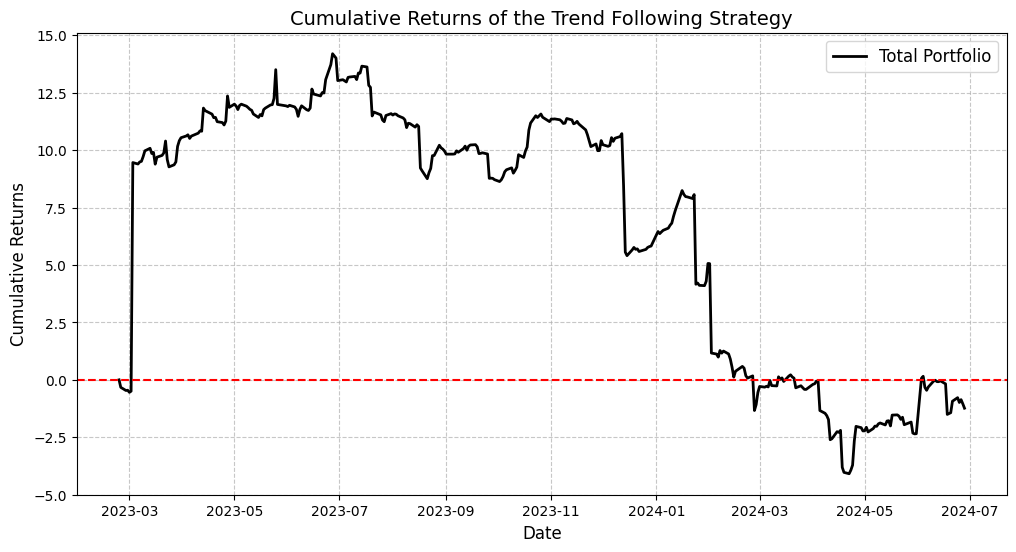

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Replace NaN and infinite values
profit_columns = [f"Profit {col}" for col in columns]
test_data[profit_columns] = test_data[profit_columns].fillna(0)
test_data[profit_columns] = test_data[profit_columns].replace([np.inf, -np.inf], 0)

# Calculate cumulative returns for the portfolio
cumulative_returns = test_data[profit_columns].sum(axis=1).cumsum()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, color='black', linewidth=2, label='Total Portfolio')

# Add a horizontal red line at y=0
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)

# Add labels, title, and legend
plt.title('Cumulative Returns of the Trend Following Strategy', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
